## import packages and intake catalog

In [23]:
#import packages
import numpy as np
import xarray as xr
import netCDF4 as nc
import matplotlib.pyplot as plt
import os
import seaborn as sns

In [24]:
#copy your local directory here
os.chdir('/Users/emmalayton/Desktop/senior_thesis/RFMIP-IRF_intake_catalogue/')

In [25]:
#open the catalog and experiment info
from intake import open_catalog
cat = open_catalog(os.getcwd() + '/main.yml')
extrainfo = xr.open_dataset(os.getcwd() + '/multiple_input4MIPs_radiation_RFMIP_UColorado-RFMIP-1-2_none.nc').to_dataframe()

## import data and compute global means

In [26]:
#scale RRTMG p1f1 data since it uses different boundary conditions than RFMIP protocol
#find the scaling factor at the boundary (top of atmosphere)
rrtmg_p1f1_scale = cat.benchmark.LBLRTM.p1f1.rsd.to_dask().rsd.isel(level=0)/cat.parameterized.RRTMG.p1f1.rsd.to_dask().rsd.isel(level=0)
#concatenate the RRTMG data
adjusted_rrtmg = xr.concat([cat.parameterized.RRTMG.p1f1[f].to_dask()
                for f in ["rsu","rsd", "rlu", "rld"]],
                dim="field", data_vars = "different")
adjusted_rrtmg['rsu'] = rrtmg_p1f1_scale*adjusted_rrtmg['rsu']
adjusted_rrtmg['rsd'] = rrtmg_p1f1_scale*adjusted_rrtmg['rsd']

/Applications/anaconda3/envs/RFMIP/lib/python3.9/site-packages/xarray/conventions.py:521: SerializationWarning: variable 'rsd' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/Applications/anaconda3/envs/RFMIP/lib/python3.9/site-packages/xarray/conventions.py:521: SerializationWarning: variable 'rsd' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/Applications/anaconda3/envs/RFMIP/lib/python3.9/site-packages/xarray/conventions.py:521: SerializationWarning: variable 'rsu' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/Applications/anaconda3/envs/RFMIP/lib/python3.9/site-packages/xarray/conventions.py:521: SerializationWarning: variable 'rlu' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/Applications/anaconda3/envs/RFMIP/lib/python3.9/site-packages/xarray/co

In [27]:
#values at TOA (level=0) are the same
print((adjusted_rrtmg['rsd']-cat.benchmark.LBLRTM.p1f1.rsd.to_dask().rsd).isel(level=0).max())
#profile weights are the same
adjusted_rrtmg.profile_weight-cat.benchmark.LBLRTM.p1f1.rsd.to_dask().profile_weight
#computed global means are much higher for RRTMG than other parameterized models (see below)

<xarray.DataArray 'rsd' ()>
array(6.1035156e-05, dtype=float32)


<xarray.DataArray 'profile_weight' (site: 100)>
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)
Coordinates:
    lat      (site) float32 -28.5 28.5 31.5 87.0 36.0 ... 64.5 58.5 -3.0 -24.0
    lon      (site) float32 27.0 24.0 162.0 126.0 66.0 ... 3.0 184.5 250.5 246.0
    time     (site) datetime64[ns] 2014-01-05T06:00:00 ... 2014-12-30
Dimensions without coordinates: site

In [28]:
#method to compute weighted global mean
def compute_global_mean(ds):
    wts = ds.profile_weight/ds.profile_weight.sum()
    return(ds.weighted(wts).mean(["site"]))

In [29]:
#store globally averaged benchmark/line-by-line model data in a dataframe, divided by shortwave/longwave and up/down
gbms_b = {}
for m in list(cat.benchmark):
#    print("Trying model ", m)
    for r in list(cat.benchmark[m]):
        components = list(cat.benchmark[m][r])
        gbms_b[f'{m}_{r}'] = xr.concat([compute_global_mean(cat.benchmark[m][r][f].to_dask()) 
                                        for f in components], 
                                        dim="field", data_vars = "different")
        if "rsd" in components:
            gbms_b[f'{m}_{r}'] = gbms_b[f'{m}_{r}'].assign(rsn=gbms_b[f'{m}_{r}'].data_vars['rsd']-gbms_b[f'{m}_{r}'].data_vars['rsu'])

gbms_b = {k: gbms_b[k].assign(rln=gbms_b[k].data_vars['rld']-gbms_b[k].data_vars['rlu']) for k in gbms_b.keys()}
gbms_b = {k: gbms_b[k].assign_coords(expt=extrainfo['expt_label'].unique()) for k in gbms_b.keys()}

/Applications/anaconda3/envs/RFMIP/lib/python3.9/site-packages/xarray/conventions.py:521: SerializationWarning: variable 'rlu' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/Applications/anaconda3/envs/RFMIP/lib/python3.9/site-packages/xarray/conventions.py:521: SerializationWarning: variable 'rld' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/Applications/anaconda3/envs/RFMIP/lib/python3.9/site-packages/xarray/conventions.py:521: SerializationWarning: variable 'rsu' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/Applications/anaconda3/envs/RFMIP/lib/python3.9/site-packages/xarray/conventions.py:521: SerializationWarning: variable 'rlu' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/Applications/anaconda3/envs/RFMIP/lib/python3.9/site-packages/xarray/co

In [30]:
#store globally averaged parameterized model data in dataframe, divided by shortwave/longwave 
gbms = {}
for m in list(cat.parameterized):
    for r in list(cat.parameterized[m]):
#        if "RRTMG" in m and "RTE_RRTMGP" not in m:
#            gbms[f'{m}_{r}'] = compute_global_mean(adjusted_rrtmg)
#        else:
        gbms[f'{m}_{r}'] = xr.concat([compute_global_mean(cat.parameterized[m][r][f].to_dask()) 
                            for f in ["rlu","rld","rsu","rsd"]], 
                            dim="field", data_vars = "different")

gbms = {k: gbms[k].assign(rln=gbms[k].data_vars['rld']-gbms[k].data_vars['rlu']) for k in gbms.keys()}
gbms = {k: gbms[k].assign(rsn=gbms[k].data_vars['rsd']-gbms[k].data_vars['rsu']) for k in gbms.keys()}
gbms = {k: gbms[k].assign_coords(expt=extrainfo['expt_label'].unique()) for k in gbms.keys()}

/Applications/anaconda3/envs/RFMIP/lib/python3.9/site-packages/xarray/conventions.py:521: SerializationWarning: variable 'rlu' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/Applications/anaconda3/envs/RFMIP/lib/python3.9/site-packages/xarray/conventions.py:521: SerializationWarning: variable 'rld' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/Applications/anaconda3/envs/RFMIP/lib/python3.9/site-packages/xarray/conventions.py:521: SerializationWarning: variable 'rsu' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/Applications/anaconda3/envs/RFMIP/lib/python3.9/site-packages/xarray/conventions.py:521: SerializationWarning: variable 'rsd' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/Applications/anaconda3/envs/RFMIP/lib/python3.9/site-packages/xarray/co

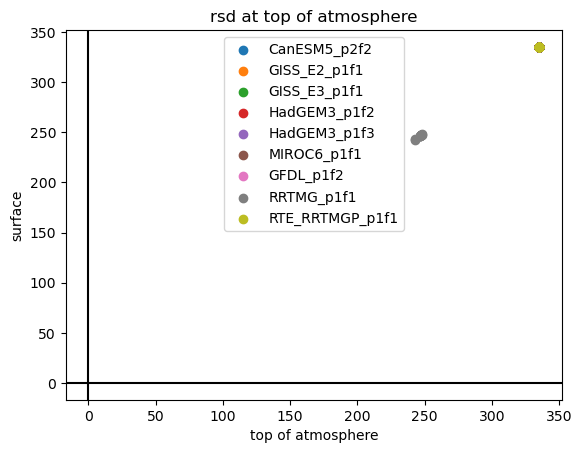

In [31]:
#show that the RRTMG input is different than the other RFMIP models
fig, ax = plt.subplots()
for m in list(gbms.keys()):
    plt.scatter(gbms[m].data_vars["rsd"][:,0],gbms[m].data_vars["rsd"][:,0])
#plt.scatter(gbmforcing_b[0,:,0],gbmforcing_b[0,:,1])
plt.xlabel("top of atmosphere")
plt.ylabel("surface")
ax.axhline(y=0, color='k')
ax.axvline(x=0, color='k')
plt.legend(list(gbms.keys()))
plt.title("rsd at top of atmosphere")
plt.show()

In [32]:
#calculate the forcing for parameterized and benchmark models by removing the present-day (experiment 0) baseline
#parameterized models
gbmforcing = gbms.copy()
for m in list(gbms.keys()):
    gbmforcing[m] = gbmforcing[m] - gbmforcing[m].isel(expt=0)
#benchmark models
gbmforcing_b = gbms_b.copy()
for m in list(gbms_b.keys()):
    gbmforcing_b[m] = gbmforcing_b[m] - gbmforcing_b[m].isel(expt=0)

In [33]:
#calculate the parameterization error using LBLRTM p1f1 as benchmark
gbme = {k: (gbmforcing[k]-gbmforcing_b['LBLRTM_p1f1']) for k in gbmforcing.keys()}

## visualize data

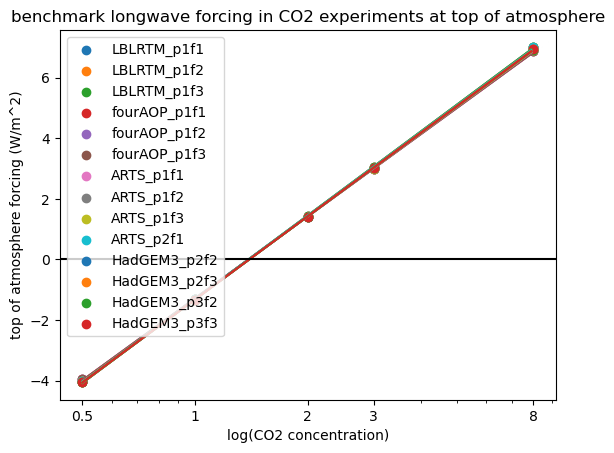

In [34]:
#benchmark longwave forcing in CO2 experiments at TOA

fig, ax = plt.subplots()

#plot data
for m in list(gbmforcing_b.keys()):
    plt.scatter([0.5, 1, 2, 3, 8], gbmforcing_b[m].data_vars["rln"].sel(expt=['0.5xCO2', 'PI CO2', '2xCO2', '3xCO2', '8xCO2'], level=0))

#find and plot the curve of best fit
for m in list(gbmforcing_b.keys()):
    t = np.log10([0.5, 1, 2, 3, 8])
    y = gbmforcing_b[m].data_vars["rln"].sel(expt=['0.5xCO2', 'PI CO2', '2xCO2', '3xCO2', '8xCO2'], level=0)
    p = np.polyfit(t, y, 1)    
    y_fitted = p[0] * np.log10(np.arange(0.5,8,0.1)) + p[1]
    plt.plot(np.arange(0.5,8,0.1),y_fitted)

#scale logarithmcially and label tick marks and axes
plt.ylabel("top of atmosphere forcing (W/m^2)")
plt.xscale('log')
ax.set_xticks([0.5, 1, 2, 3, 8])
ax.set_xticklabels([0.5, 1, 2, 3, 8])
plt.xlabel("log(CO2 concentration)")
ax.axhline(y=0, color='k')
ax.axvline(x=0, color='k')
plt.title("benchmark longwave forcing in CO2 experiments at top of atmosphere")
plt.legend(list(gbmforcing_b.keys()))

plt.show()


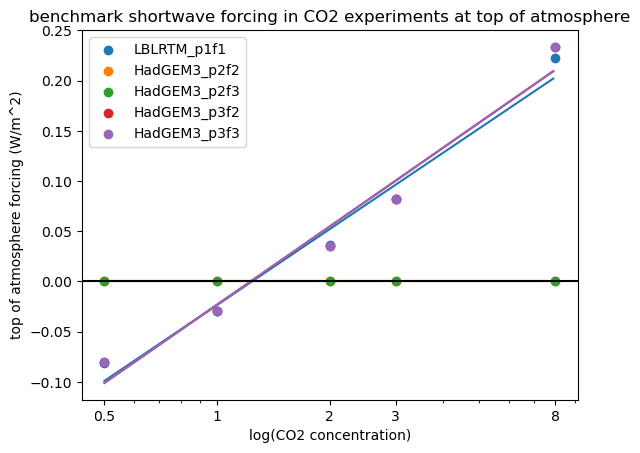

In [35]:
#benchmark shortwave forcing in CO2 experiments at TOA

fig, ax = plt.subplots()

#plot data
for m in list(gbmforcing_b.keys()):
    if 'rsn' in list(gbmforcing_b[m].data_vars):
        plt.scatter([0.5, 1, 2, 3, 8], gbmforcing_b[m].data_vars["rsn"].sel(expt=['0.5xCO2', 'PI CO2', '2xCO2', '3xCO2', '8xCO2'], level=0))

#find and plot the curve of best fit
for m in list(gbmforcing_b.keys()):
    if 'rsn' in list(gbmforcing_b[m].data_vars):
        t = np.log10([0.5, 1, 2, 3, 8])
        y = gbmforcing_b[m].data_vars["rsn"].sel(expt=['0.5xCO2', 'PI CO2', '2xCO2', '3xCO2', '8xCO2'], level=0)
        p = np.polyfit(t, y, 1)    
        y_fitted = p[0] * np.log10(np.arange(0.5,8,0.1)) + p[1]
        plt.plot(np.arange(0.5,8,0.1),y_fitted)

#scale logarithmcially and label tick marks and axes
plt.ylabel("top of atmosphere forcing (W/m^2)")
plt.xscale('log')
ax.set_xticks([0.5, 1, 2, 3, 8])
ax.set_xticklabels([0.5, 1, 2, 3, 8])
plt.xlabel("log(CO2 concentration)")
ax.axhline(y=0, color='k')
ax.axvline(x=0, color='k')
plt.title("benchmark shortwave forcing in CO2 experiments at top of atmosphere")
plt.legend(list(m for m in list(gbmforcing_b.keys()) if 'rsn' in list(gbmforcing_b[m].data_vars)))

plt.show()

#look into HadGEM3-p2f3

In [36]:
gbme['CanESM5_p2f2']

<xarray.Dataset>
Dimensions:         (expt: 18, level: 61)
Coordinates:
  * expt            (expt) object 'Present day (PD)' ... 'LGM'
Dimensions without coordinates: level
Data variables:
    rld             (expt, level) float32 0.0 0.0 0.0 ... 0.1883 0.1874 0.1802
    rsu             (expt, level) float32 0.0 0.0 0.0 ... -0.01917 -0.0193
    rsd             (expt, level) float32 0.0 0.0 0.0 ... -0.04942 -0.04921
    plev            (level) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    rlu             (expt, level) float32 0.0 0.0 0.0 ... -0.003143 0.00351
    profile_weight  float64 0.0
    rln             (expt, level) float32 0.0 0.0 0.0 ... 0.2005 0.1905 0.1767
    rsn             (expt, level) float32 0.0 0.0 0.0 ... -0.03027 -0.02991

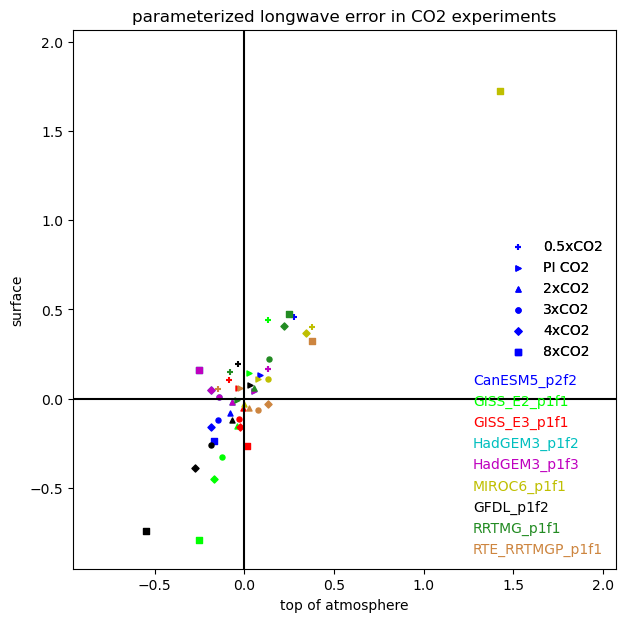

In [37]:
#parameterized longwave error in CO2 experiments
fig, ax = plt.subplots(figsize=(7,7))

#plot data
model_colors = ['b','lime','r','c','m','y','k','forestgreen','peru']
marker_shapes = ['+','>','^','o','D','s']
selected_experiments = ['0.5xCO2','PI CO2', '2xCO2', '3xCO2', '4xCO2', '8xCO2']
color_cycler = 0
for m in list(gbme.keys()):
    for i in np.arange(len(selected_experiments)):
        plt.scatter(gbme[m].data_vars["rln"][:,0].sel(expt=selected_experiments[i]),gbme[m].data_vars["rln"][:,60].sel(expt=selected_experiments[i]), c = model_colors[color_cycler], marker=marker_shapes[i], s=13)
    color_cycler+=1

#make plot square
squaremax = 0
squaremin = 0
for m in list(gbme.keys()):
    newmax = np.concatenate((gbme[m].data_vars["rln"][:,0].sel(expt=selected_experiments), gbme[m].data_vars["rln"][:,60].sel(expt=selected_experiments))).max()
    newmin = np.concatenate((gbme[m].data_vars["rln"][:,0].sel(expt=selected_experiments), gbme[m].data_vars["rln"][:,60].sel(expt=selected_experiments))).min()
    if newmax>squaremax:
        squaremax = newmax
    if newmin<squaremin:
        squaremin = newmin
plt.xlim(1.2*squaremin,1.2*squaremax)
plt.ylim(1.2*squaremin,1.2*squaremax)   
    
#label tick marks and axes    
plt.xlabel("top of atmosphere")
plt.ylabel("surface")
ax.axhline(y=0, color='k')
ax.axvline(x=0, color='k')

#create the legend
legend1 = ax.legend(labels=gbme.keys(), loc='lower right', markerscale=0, labelcolor=model_colors, fontsize=10, frameon=False)
legend2 = ax.legend(labels=selected_experiments, loc='center right', frameon=False, markerscale=1)
ax.add_artist(legend1)
ax.add_artist(legend2)

plt.title("parameterized longwave error in CO2 experiments")
plt.show()

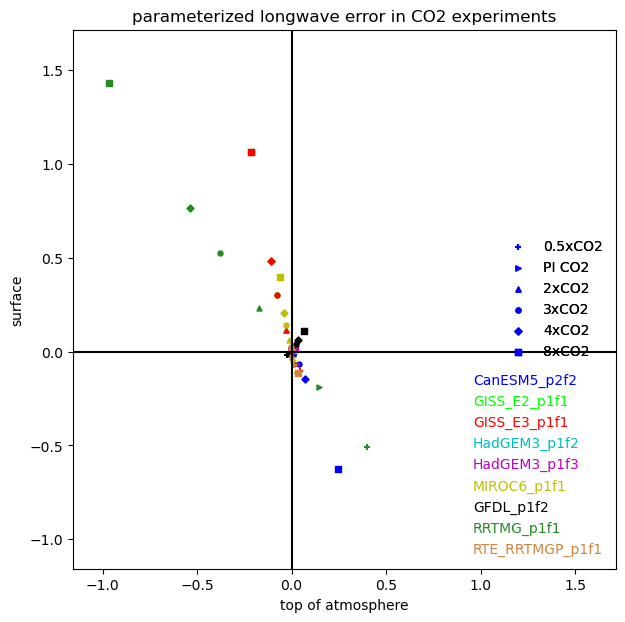

In [38]:
#parameterized longwave error in CO2 experiments
fig, ax = plt.subplots(figsize=(7,7))

#plot data
model_colors = ['b','lime','r','c','m','y','k','forestgreen','peru']
marker_shapes = ['+','>','^','o','D','s']
selected_experiments = ['0.5xCO2','PI CO2', '2xCO2', '3xCO2', '4xCO2', '8xCO2']
color_cycler = 0
for m in list(gbme.keys()):
    for i in np.arange(len(selected_experiments)):
        plt.scatter(gbme[m].data_vars["rsn"][:,0].sel(expt=selected_experiments[i]),gbme[m].data_vars["rsn"][:,60].sel(expt=selected_experiments[i]), c = model_colors[color_cycler], marker=marker_shapes[i], s=13)
    color_cycler+=1

#make plot square
squaremax = 0
squaremin = 0
for m in list(gbme.keys()):
    newmax = np.concatenate((gbme[m].data_vars["rsn"][:,0].sel(expt=selected_experiments), gbme[m].data_vars["rsn"][:,60].sel(expt=selected_experiments))).max()
    newmin = np.concatenate((gbme[m].data_vars["rsn"][:,0].sel(expt=selected_experiments), gbme[m].data_vars["rsn"][:,60].sel(expt=selected_experiments))).min()
    if newmax>squaremax:
        squaremax = newmax
    if newmin<squaremin:
        squaremin = newmin
plt.xlim(1.2*squaremin,1.2*squaremax)
plt.ylim(1.2*squaremin,1.2*squaremax)   
    
#label tick marks and axes    
plt.xlabel("top of atmosphere")
plt.ylabel("surface")
ax.axhline(y=0, color='k')
ax.axvline(x=0, color='k')

#create the legend
legend1 = ax.legend(labels=gbme.keys(), loc='lower right', markerscale=0, labelcolor=model_colors, fontsize=10, frameon=False)
legend2 = ax.legend(labels=selected_experiments, loc='center right', frameon=False, markerscale=1)
ax.add_artist(legend1)
ax.add_artist(legend2)

plt.title("parameterized longwave error in CO2 experiments")
plt.show()

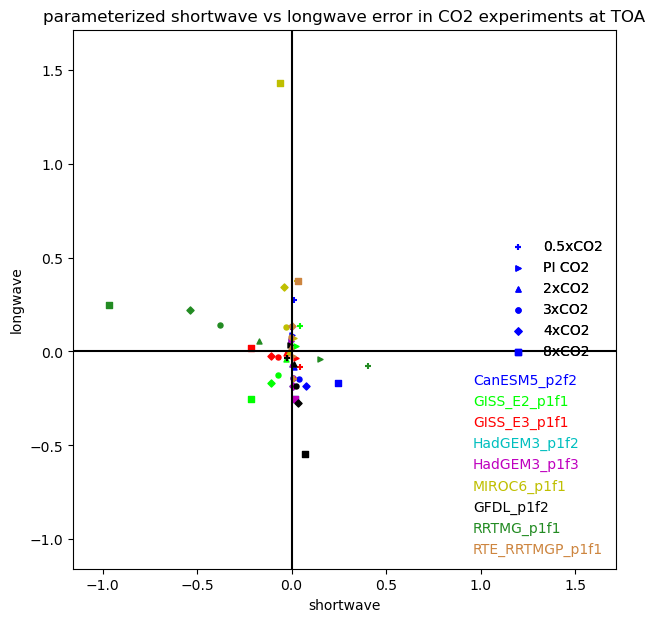

In [39]:
#parameterized longwave error in CO2 experiments
fig, ax = plt.subplots(figsize=(7,7))

#plot data
model_colors = ['b','lime','r','c','m','y','k','forestgreen','peru']
marker_shapes = ['+','>','^','o','D','s']
selected_experiments = ['0.5xCO2','PI CO2', '2xCO2', '3xCO2', '4xCO2', '8xCO2']
color_cycler = 0
for m in list(gbme.keys()):
    for i in np.arange(len(selected_experiments)):
        plt.scatter(gbme[m].data_vars["rsn"][:,0].sel(expt=selected_experiments[i]),gbme[m].data_vars["rln"][:,0].sel(expt=selected_experiments[i]), c = model_colors[color_cycler], marker = marker_shapes[i], s=13)
    color_cycler+=1

#make plot square
squaremax = 0
squaremin = 0
for m in list(gbme.keys()):
    newmax = np.concatenate((gbme[m].data_vars["rsn"][:,0].sel(expt=selected_experiments), gbme[m].data_vars["rln"][:,0].sel(expt=selected_experiments))).max()
    newmin = np.concatenate((gbme[m].data_vars["rsn"][:,0].sel(expt=selected_experiments), gbme[m].data_vars["rln"][:,0].sel(expt=selected_experiments))).min()
    if newmax>squaremax:
        squaremax = newmax
    if newmin<squaremin:
        squaremin = newmin
plt.xlim(1.2*squaremin,1.2*squaremax)
plt.ylim(1.2*squaremin,1.2*squaremax)   
    
#label tick marks and axes    
plt.xlabel("shortwave")
plt.ylabel("longwave")
ax.axhline(y=0, color='k')
ax.axvline(x=0, color='k')

#create the legend
legend1 = ax.legend(labels=gbme.keys(), loc='lower right', markerscale=0, labelcolor=model_colors, fontsize=10, frameon=False)
legend2 = ax.legend(labels=selected_experiments, loc='center right', frameon=False, markerscale=1)
ax.add_artist(legend1)
ax.add_artist(legend2)

plt.title("parameterized shortwave vs longwave error in CO2 experiments at TOA")
plt.show()

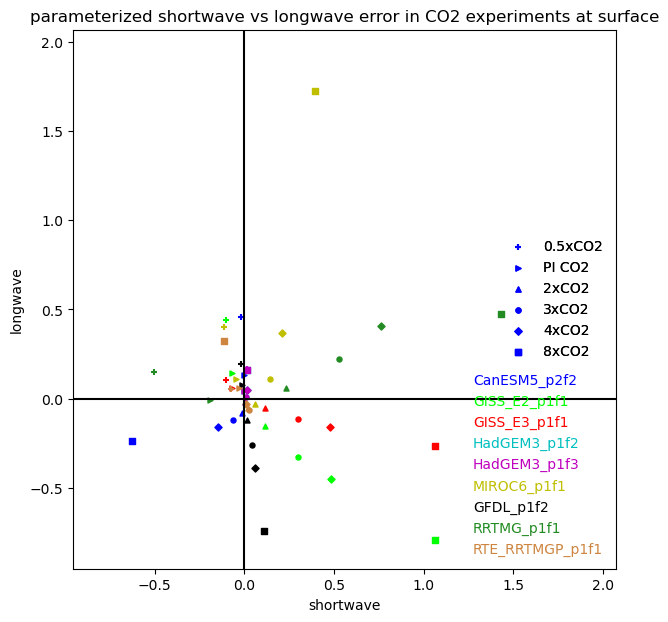

In [40]:
#parameterized longwave error in CO2 experiments
fig, ax = plt.subplots(figsize=(7,7))

#plot data
model_colors = ['b','lime','r','c','m','y','k','forestgreen','peru']
marker_shapes = ['+','>','^','o','D','s']
selected_experiments = ['0.5xCO2','PI CO2', '2xCO2', '3xCO2', '4xCO2', '8xCO2']
color_cycler = 0
for m in list(gbme.keys()):
    for i in np.arange(len(selected_experiments)):
        plt.scatter(gbme[m].data_vars["rsn"][:,60].sel(expt=selected_experiments[i]),gbme[m].data_vars["rln"][:,60].sel(expt=selected_experiments[i]), c = model_colors[color_cycler], marker = marker_shapes[i], s=13)
    color_cycler+=1

#make plot square
squaremax = 0
squaremin = 0
for m in list(gbme.keys()):
    newmax = np.concatenate((gbme[m].data_vars["rsn"][:,60].sel(expt=selected_experiments), gbme[m].data_vars["rln"][:,60].sel(expt=selected_experiments))).max()
    newmin = np.concatenate((gbme[m].data_vars["rsn"][:,60].sel(expt=selected_experiments), gbme[m].data_vars["rln"][:,60].sel(expt=selected_experiments))).min()
    if newmax>squaremax:
        squaremax = newmax
    if newmin<squaremin:
        squaremin = newmin
plt.xlim(1.2*squaremin,1.2*squaremax)
plt.ylim(1.2*squaremin,1.2*squaremax)   
    
#label tick marks and axes    
plt.xlabel("shortwave")
plt.ylabel("longwave")
ax.axhline(y=0, color='k')
ax.axvline(x=0, color='k')

#create the legend
legend1 = ax.legend(labels=gbme.keys(), loc='lower right', markerscale=0, labelcolor=model_colors, fontsize=10, frameon=False)
legend2 = ax.legend(labels=selected_experiments, loc='center right', frameon=False, markerscale=1)
ax.add_artist(legend1)
ax.add_artist(legend2)

plt.title("parameterized shortwave vs longwave error in CO2 experiments at surface")
plt.show()

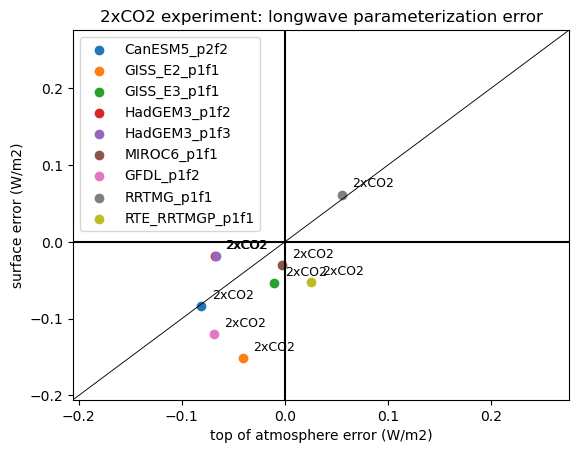

In [75]:
#parameterized longwave error in 2xCO2 experiment
fig, ax = plt.subplots()
selected_experiments = ['2xCO2']

#plot data
for m in list(gbme.keys()):
    plt.scatter(gbme[m].data_vars["rln"][:,0].sel(expt=selected_experiments),gbme[m].data_vars["rln"][:,60].sel(expt=selected_experiments))
    for i in range(len(gbme[m].expt)):
        if gbme[m].expt[i].values in selected_experiments:
            plt.text(gbme[m].data_vars["rln"][i,0]+0.01,gbme[m].data_vars["rln"][i,60]+0.01, gbme[m].expt[i].values, fontsize=9)    

#make plot square
squaremax = 0
squaremin = 0
for m in list(gbme.keys()):
    newmax = np.concatenate((gbme[m].data_vars["rsn"][:,0].sel(expt=selected_experiments), gbme[m].data_vars["rsn"][:,60].sel(expt=selected_experiments))).max()
    newmin = np.concatenate((gbme[m].data_vars["rsn"][:,0].sel(expt=selected_experiments), gbme[m].data_vars["rsn"][:,60].sel(expt=selected_experiments))).min()
    if newmax>squaremax:
        squaremax = newmax
    if newmin<squaremin:
        squaremin = newmin
plt.xlim(1.2*squaremin,1.2*squaremax)
plt.ylim(1.2*squaremin,1.2*squaremax)   

#plot isolines
x = np.linspace(1.2*squaremin,1.2*squaremax, 1000)
plt.plot(x,x,'k',linestyle='solid', linewidth=0.65)

plt.xlabel("top of atmosphere error (W/m2)")
plt.ylabel("surface error (W/m2)")
ax.axhline(y=0, color='k')
ax.axvline(x=0, color='k')
plt.legend(list(gbme.keys()))
plt.title("2xCO2 experiment: longwave parameterization error")
plt.show()

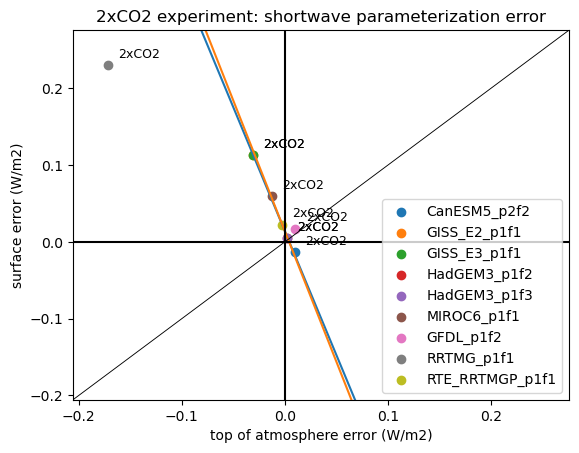

In [46]:
#parameterized shortwave error in 2xCO2 experiment
fig, ax = plt.subplots()

#plot data
x = np.zeros(0) #x and y will be used to plot a trendline with model data
y = np.zeros(0)
selected_experiments = ['2xCO2']
for m in list(gbme.keys()):
    plt.scatter(gbme[m].data_vars["rsn"][:,0].sel(expt=selected_experiments),gbme[m].data_vars["rsn"][:,60].sel(expt=selected_experiments))
    if "RRTMG_p1f1" not in m:
        if "GFDL_p1f2" not in m:
            x = np.append(x, gbme[m].data_vars["rsn"][:,0].sel(expt=selected_experiments))
            y = np.append(y, gbme[m].data_vars["rsn"][:,60].sel(expt=selected_experiments))
    for i in range(len(gbme[m].expt)):
        if gbme[m].expt[i].values in selected_experiments:
            plt.text(gbme[m].data_vars["rsn"][i,0]+0.01,gbme[m].data_vars["rsn"][i,60]+0.01, gbme[m].expt[i].values, fontsize=9)

#make plot square
squaremax = 0
squaremin = 0
for m in list(gbme.keys()):
    newmax = np.concatenate((gbme[m].data_vars["rsn"][:,0].sel(expt=selected_experiments), gbme[m].data_vars["rsn"][:,60].sel(expt=selected_experiments))).max()
    newmin = np.concatenate((gbme[m].data_vars["rsn"][:,0].sel(expt=selected_experiments), gbme[m].data_vars["rsn"][:,60].sel(expt=selected_experiments))).min()
    if newmax>squaremax:
        squaremax = newmax
    if newmin<squaremin:
        squaremin = newmin
plt.xlim(1.2*squaremin,1.2*squaremax)
plt.ylim(1.2*squaremin,1.2*squaremax)     

#plot a line of best fit for models excluding GFDL and RRTMG
f, b = np.polyfit(x,y, 1)
plt.plot(np.arange(squaremin,squaremax,0.1), np.arange(squaremin,squaremax,0.1)*f + b)

#plot a line with slope -1/2(alpha)
plt.plot(np.arange(squaremin,squaremax,0.1), np.arange(squaremin,squaremax,0.1)*-3.4 + b)

#plot 1:1 isoline
x = np.linspace(1.2*squaremin,1.2*squaremax, 1000)
plt.plot(x,x,'k',linestyle='solid', linewidth=0.65)

plt.xlabel("top of atmosphere error (W/m2)")
plt.ylabel("surface error (W/m2)")
ax.axhline(y=0, color='k')
ax.axvline(x=0, color='k')
plt.legend([k for k in gbme.keys()])
plt.title("2xCO2 experiment: shortwave parameterization error")
plt.show()

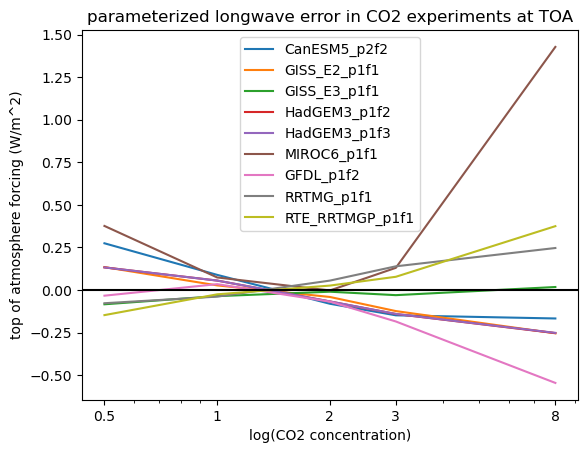

In [76]:
#parameterized longwave error in CO2 experiments at TOA
fig, ax = plt.subplots()

#plot data
for m in list(gbme.keys()):
    plt.plot([0.5, 1, 2, 3, 8], gbme[m].data_vars["rln"].sel(expt=['0.5xCO2', 'PI CO2', '2xCO2', '3xCO2', '8xCO2'], level=0))
'''
#find and plot the curve of best fit    
for m in list(gbme.keys()):
    t = np.log10([0.5, 1, 2, 3, 8])
    y = gbme[m].data_vars["rln"].sel(expt=['0.5xCO2', 'PI CO2', '2xCO2', '3xCO2', '8xCO2'], level=0)
    p = np.polyfit(t, y, 1)    
    y_fitted = p[0] * np.log10(np.arange(0.5,8,0.1)) + p[1]
    plt.plot(np.arange(0.5,8,0.1),y_fitted)
    print(m+":"+str(p[0]))
'''
#scale logarithmically and label tick marks and axes
plt.ylabel("top of atmosphere forcing (W/m^2)")
plt.xscale('log')
ax.set_xticks([0.5, 1, 2, 3, 8])
ax.set_xticklabels([0.5, 1, 2, 3, 8])
plt.xlabel("log(CO2 concentration)")
ax.axhline(y=0, color='k')
ax.axvline(x=0, color='k')
plt.legend(gbme.keys())
plt.title("parameterized longwave error in CO2 experiments at TOA")
plt.show()

CanESM5_p2f2:0.18306862433933763
GISS_E2_p1f1:-0.21554843331845128
GISS_E3_p1f1:-0.2155384456916925
HadGEM3_p1f2:0.019301109661686973
HadGEM3_p1f3:0.019301109661686973
MIROC6_p1f1:-0.07568127180396073
GFDL_p1f2:0.07587115121044319
RRTMG_p1f1:-1.1346942589159794
RTE_RRTMGP_p1f1:0.014828827593866202


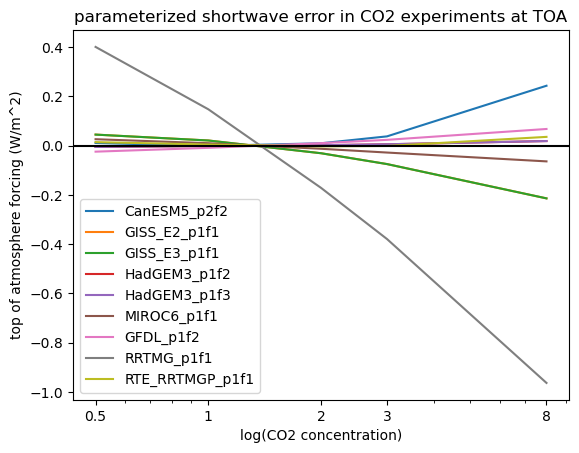

In [77]:
#parameterized shortwave error in CO2 experiments at TOA
fig, ax = plt.subplots()

#plot data
for m in list(gbme.keys()):
    plt.plot([0.5, 1, 2, 3, 8], gbme[m].data_vars["rsn"].sel(expt=['0.5xCO2', 'PI CO2', '2xCO2', '3xCO2', '8xCO2'], level=0))

#find and plot the curve of best fit    
for m in list(gbme.keys()):
    t = np.log10([0.5, 1, 2, 3, 8])
    y = gbme[m].data_vars["rsn"].sel(expt=['0.5xCO2', 'PI CO2', '2xCO2', '3xCO2', '8xCO2'], level=0)
    p = np.polyfit(t, y, 1)    
    y_fitted = p[0] * np.log10([0.5,1,2,3,8]) + p[1]
#    plt.plot(np.arange(0.5,8,0.1),y_fitted)
    print(m+":"+str(p[0]))


#scale logarithmically and label tick marks and axes
plt.ylabel("top of atmosphere forcing (W/m^2)")
plt.xscale('log')
ax.set_xticks([0.5, 1, 2, 3, 8])
ax.set_xticklabels([0.5, 1, 2, 3, 8])
plt.xlabel("log(CO2 concentration)")
ax.axhline(y=0, color='k')
ax.axvline(x=0, color='k')
plt.legend(gbme.keys())
plt.title("parameterized shortwave error in CO2 experiments at TOA")
plt.show()

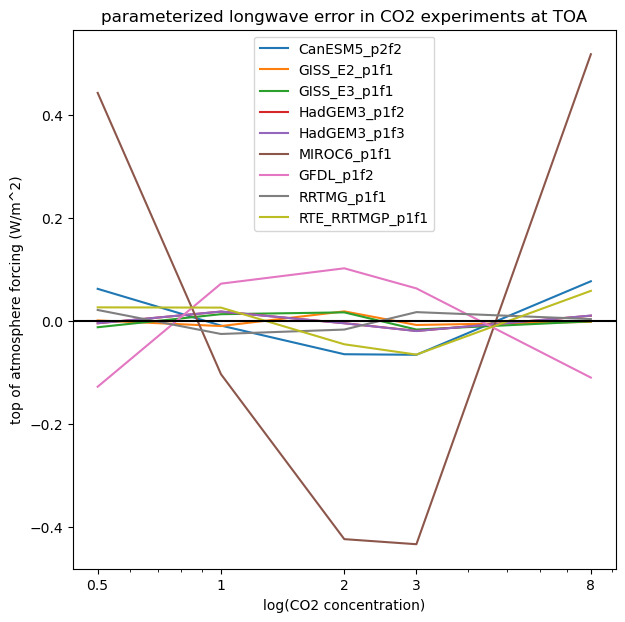

In [81]:
#plot longwave parameterization error deviation from logarithmic (by model realization)
fig, ax = plt.subplots(figsize=(7,7))

deviation = {}

#find a logarithmic model for each realization    
for m in list(gbme.keys()):
    t = np.log10([0.5, 1, 2, 3, 8])
    y = gbme[m].data_vars["rln"].sel(expt=['0.5xCO2', 'PI CO2', '2xCO2', '3xCO2', '8xCO2'], level=0)
    p = np.polyfit(t, y, 1)    
    y_model = p[0] * np.log10([0.5,1,2,3,8]) + p[1]
    deviation.update({str(m): y-y_model})

#plot the deviation from the logarithmic model
for m in list(gbme.keys()):
    plt.plot([0.5, 1, 2, 3, 8], deviation[m])

#scale logarithmically and label tick marks and axes
plt.ylabel("top of atmosphere forcing (W/m^2)")
plt.xscale('log')
ax.set_xticks([0.5, 1, 2, 3, 8])
ax.set_xticklabels([0.5, 1, 2, 3, 8])
plt.xlabel("log(CO2 concentration)")
ax.axhline(y=0, color='k')
ax.axvline(x=0, color='k')
plt.legend(gbme.keys())
plt.title("parameterized longwave error in CO2 experiments at TOA")
plt.show()

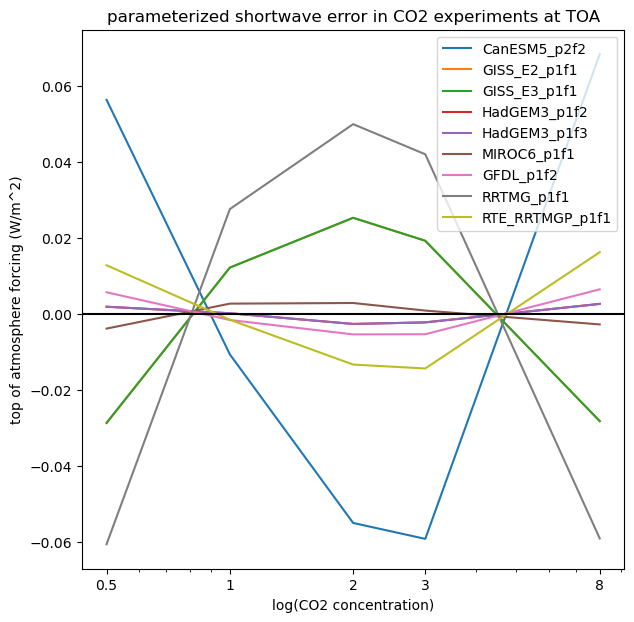

In [82]:
#plot shortwave parameterization error deviation from logarithmic (by model realization)
fig, ax = plt.subplots(figsize=(7,7))

deviation = {}

#find a logarithmic model for each realization    
for m in list(gbme.keys()):
    t = np.log10([0.5, 1, 2, 3, 8])
    y = gbme[m].data_vars["rsn"].sel(expt=['0.5xCO2', 'PI CO2', '2xCO2', '3xCO2', '8xCO2'], level=0)
    p = np.polyfit(t, y, 1)    
    y_model = p[0] * np.log10([0.5,1,2,3,8]) + p[1]
    deviation.update({str(m): y-y_model})

#plot the deviation from the logarithmic model
for m in list(gbme.keys()):
    plt.plot([0.5, 1, 2, 3, 8], deviation[m])

#scale logarithmically and label tick marks and axes
plt.ylabel("top of atmosphere forcing (W/m^2)")
plt.xscale('log')
ax.set_xticks([0.5, 1, 2, 3, 8])
ax.set_xticklabels([0.5, 1, 2, 3, 8])
plt.xlabel("log(CO2 concentration)")
ax.axhline(y=0, color='k')
ax.axvline(x=0, color='k')
plt.legend(gbme.keys())
plt.title("parameterized shortwave error in CO2 experiments at TOA")
plt.show()